In [50]:
import utilities
import os
import socket
import tldextract
import pandas as pd

In [51]:
base_dir = "/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/Traffic"
dns = utilities.read_json("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/post_processed/encrypted_echo/general_dns_resolutions.json")
categories_echo = utilities.get_directories_in_a_directory("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/Traffic/Traffic_echo_1.1.1.1/")

#### create a table of category | skill_name | FQDN | eSLD | subdomains |organization | ATSes | party

In [66]:
df = {'cat': [], 'skill_name': [], 'fqdn': [], 'domain_name': [], 'SLD': [], 'subdomain' : [] ,'organization': [], 'ATSes': [], 'Party': []}
for category in categories_echo:
    category_name = category.split('/')[-1]
    jsons = utilities.get_files_in_a_directory(os.path.join(category, "jsons"))
    for skill in jsons:
        ip_list = set()
        skill_name = skill.split('/')[-1].split('.')[0]
        skill_network_json = utilities.read_json(skill)
        for i in range(len(skill_network_json)):
            if 'ip' in skill_network_json[i]["_source"]["layers"].keys():
                ip_src =  skill_network_json[i]["_source"]["layers"]['ip']['ip.src']
                ip_dst =   skill_network_json[i]["_source"]["layers"]['ip']['ip.dst']
                if not ip_src.startswith("10.42."):
                    if ip_src not in ip_list:
                        ip_list.add(ip_src)
                        df['cat'].append(category_name)
                        df['skill_name'].append(skill_name)
                        if ip_src in dns:
                            df['fqdn'].append(dns[ip_src])
                            ext = tldextract.extract(dns[ip_src])
                            df['domain_name'].append(ext.domain+"."+ext.suffix)
                            df['subdomain'].append(ext.subdomain)
                            df['SLD'].append(ext.domain)
                            
                        else:
                            df['fqdn'].append(ip_src)
                            df['domain_name'] = ""
                            df['subdomain'].append("")
                            df['SLD'].append("")
                        df['organization'].append("")
                        df['ATSes'].append("")
                        df['Party'].append("")
                        
                if not ip_dst.startswith("10.42."):
                    if ip_dst not in ip_list:
                        ip_list.add(ip_dst)
                        df['cat'].append(category_name)
                        df['skill_name'].append(skill_name)
                        if ip_dst in dns:
                            df['fqdn'].append(dns[ip_dst])
                            ext = tldextract.extract(dns[ip_dst])
                            df['domain_name'].append(ext.domain+"."+ext.suffix)
                            df['subdomain'].append(ext.subdomain)
                            df['SLD'].append(ext.domain)
                        else:
                            df['fqdn'].append(ip_dst)
                            df['domain_name'].append("")
                            df['subdomain'].append("")
                            df['SLD'].append("")
                        df['organization'].append("")
                        df['ATSes'].append("")
                        df['Party'].append("")

# Save dataframe in csv format

In [67]:
df = pd.DataFrame.from_dict(df)
df.to_csv("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/report.csv", sep=',')
df

,cat,skill_name,fqdn,domain_name,SLD,subdomain,organization,ATSes,Party
0,Fashion-Style,B083PY1PGZ,bob-dispatch-prod-na.amazon.com,amazon.com,amazon,bob-dispatch-prod-na,,,
1,Fashion-Style,B083PY1PGZ,ec2-54-166-14-123.compute-1.amazonaws.com,amazonaws.com,amazonaws,ec2-54-166-14-123.compute-1,,,
2,Fashion-Style,B087YM4KJK,mlis.amazon.com,amazon.com,amazon,mlis,,,
3,Fashion-Style,B087YM4KJK,bob-dispatch-prod-na.amazon.com,amazon.com,amazon,bob-dispatch-prod-na,,,
4,Fashion-Style,B087YM4KJK,d1gsg05rq1vjdw.cloudfront.net,cloudfront.net,cloudfront,d1gsg05rq1vjdw,,,
...,...,...,...,...,...,...,...,...,...
2790,Health-Fitness,B07PJWHYXM,d3p8zr0ffa9t17.cloudfront.net,cloudfront.net,cloudfront,d3p8zr0ffa9t17,,,
2791,Health-Fitness,B07PJWHYXM,d1gsg05rq1vjdw.cloudfront.net,cloudfront.net,cloudfront,d1gsg05rq1vjdw,,,
2792,Health-Fitness,B07PJWHYXM,ec2-34-198-99-173.compute-1.amazonaws.com,amazonaws.com,amazonaws,ec2-34-198-99-173.compute-1,,,
2793,Health-Fitness,B07PJWHYXM,mlis.amazon.com,amazon.com,amazon,mlis,,,


# Unique Domain Names

In [88]:
unique_df = {}
for index, row in df.iterrows():
    if row['fqdn'] not in unique_df:
        unique_df[row['fqdn']] = {'domain_name': row['domain_name'], 'SLD': row['SLD'], 'subdomain' : row['subdomain'] ,'organization': "", 'ATSes': "", 'Party': ""}

## Address Organization

In [94]:
ddg_entities = utilities.get_files_in_a_directory("/home/c2/alexa/post-processing/tracker-radar/entities")

for fqdn, details in unique_df.items():
    for entity in ddg_entities:
        entity_content = utilities.read_json(entity)
        if details['domain_name'] in entity_content["properties"]:
            details['organization'] = entity_content["name"]

####  For organizations we didn't find on DDG, we use https://lookup.icann.org/lookup and crunchbase.com

In [97]:
non_org_in_ddg = {}
for fqdn, details in unique_df.items(): 
    if details['organization'] == '':
        if fqdn not in non_org_in_ddg:
            non_org_in_ddg[fqdn] = details['domain_name']
#utilities.write_json("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/non_org_in_ddg.json", dict(non_org_in_ddg))

## Address ATSes

In [ ]:
filter_list_base = "/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/filter_lists/"
trackers = utilities.read_json(os.path.join(filter_list_base, "trackers.json"))
advertisers = utilities.read_json(os.path.join(filter_list_base, "advertisers.json"))

## Read dataframe

In [23]:
# import csv 
# import pandas as pd
# df = pd.read_csv("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/report.csv")
# df

,Unnamed: 0,cat,skill_name,fqdn,domain_name,SLD,subdomain,organization,ATSes,Party
0,0,Fashion-Style,B083PY1PGZ,bob-dispatch-prod-na.amazon.com,amazon.com,amazon,bob-dispatch-prod-na,NaN,NaN,NaN
1,1,Fashion-Style,B083PY1PGZ,ec2-54-166-14-123.compute-1.amazonaws.com,amazon.com,amazonaws,ec2-54-166-14-123.compute-1,NaN,NaN,NaN
2,2,Fashion-Style,B087YM4KJK,mlis.amazon.com,amazon.com,amazon,mlis,NaN,NaN,NaN
3,3,Fashion-Style,B087YM4KJK,bob-dispatch-prod-na.amazon.com,amazon.com,amazon,bob-dispatch-prod-na,NaN,NaN,NaN
4,4,Fashion-Style,B087YM4KJK,d1gsg05rq1vjdw.cloudfront.net,amazon.com,cloudfront,d1gsg05rq1vjdw,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2790,2790,Health-Fitness,B07PJWHYXM,d3p8zr0ffa9t17.cloudfront.net,amazon.com,cloudfront,d3p8zr0ffa9t17,NaN,NaN,NaN
2791,2791,Health-Fitness,B07PJWHYXM,d1gsg05rq1vjdw.cloudfront.net,cloudfront.net,cloudfront,d1gsg05rq1vjdw,NaN,NaN,NaN
2792,2792,Health-Fitness,B07PJWHYXM,ec2-34-198-99-173.compute-1.amazonaws.com,cloudfront.net,amazonaws,ec2-34-198-99-173.compute-1,NaN,NaN,NaN
2793,2793,Health-Fitness,B07PJWHYXM,mlis.amazon.com,amazonaws.com,amazon,mlis,NaN,NaN,NaN


## Organizations

In [68]:
ddg_entities = utilities.get_files_in_a_directory("/home/c2/alexa/post-processing/tracker-radar/entities")
dict_domain_org = {}
for index, row in df.iterrows():
    if row['domain_name'] in dict_domain_org.keys():
        df.at[index, 'organization'] = dict_domain_org[row['domain_name']]
    else:
        for entity in ddg_entities:
            entity_content = utilities.read_json(entity)
            if row['domain_name'] in entity_content["properties"]:
                print(row['domain_name'] , entity_content["name"], end='\n')
                dict_domain_org[row['domain_name']] = entity_content["name"]
                df.at[index, 'organization'] = entity_content["name"]

amazon.com Amazon Technologies, Inc.
amazonaws.com Amazon Technologies, Inc.
cloudfront.net Amazon Technologies, Inc.
tritondigital.com Triton Digital, Inc.
libsyn.com Liberated Syndication
hwcdn.net StackPath, LLC
fastly.net Fastly, Inc.
stackpathcdn.com StackPath, LLC
cdn77.org DataCamp Limited


In [83]:
df = pd.DataFrame.from_dict(df)
df.to_csv("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/report.csv", sep=',')
df

,cat,skill_name,fqdn,domain_name,SLD,subdomain,organization,ATSes,Party
0,Fashion-Style,B083PY1PGZ,bob-dispatch-prod-na.amazon.com,amazon.com,amazon,bob-dispatch-prod-na,"Amazon Technologies, Inc.",,
1,Fashion-Style,B083PY1PGZ,ec2-54-166-14-123.compute-1.amazonaws.com,amazonaws.com,amazonaws,ec2-54-166-14-123.compute-1,"Amazon Technologies, Inc.",,
2,Fashion-Style,B087YM4KJK,mlis.amazon.com,amazon.com,amazon,mlis,"Amazon Technologies, Inc.",,
3,Fashion-Style,B087YM4KJK,bob-dispatch-prod-na.amazon.com,amazon.com,amazon,bob-dispatch-prod-na,"Amazon Technologies, Inc.",,
4,Fashion-Style,B087YM4KJK,d1gsg05rq1vjdw.cloudfront.net,cloudfront.net,cloudfront,d1gsg05rq1vjdw,"Amazon Technologies, Inc.",,
...,...,...,...,...,...,...,...,...,...
2790,Health-Fitness,B07PJWHYXM,d3p8zr0ffa9t17.cloudfront.net,cloudfront.net,cloudfront,d3p8zr0ffa9t17,"Amazon Technologies, Inc.",,
2791,Health-Fitness,B07PJWHYXM,d1gsg05rq1vjdw.cloudfront.net,cloudfront.net,cloudfront,d1gsg05rq1vjdw,"Amazon Technologies, Inc.",,
2792,Health-Fitness,B07PJWHYXM,ec2-34-198-99-173.compute-1.amazonaws.com,amazonaws.com,amazonaws,ec2-34-198-99-173.compute-1,"Amazon Technologies, Inc.",,
2793,Health-Fitness,B07PJWHYXM,mlis.amazon.com,amazon.com,amazon,mlis,"Amazon Technologies, Inc.",,


In [84]:
no_organization = set()
for index, row in df.iterrows():
    if row['organization'] == "":
        no_organization.add((row['fqdn'],row['domain_name']))
#utilities.write_json("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/no_org_with_ddg.json", dict(no_organization))

In [85]:
no_organization

{('224.0.0.251', ''),
 ('239.255.255.250', ''),
 ('255.255.255.255', ''),
 ('file.ialexa.tk', 'ialexa.tk'),
 ('files.zohopublic.in', 'zohopublic.in'),
 ('mittendorf.net', 'mittendorf.net'),
 ('zs-in2-lc1-543-h2.zohopublic.in', 'zohopublic.in')}

### Address empty organizations using ICANN and https://lookup.icann.org/lookup.crunchbase.com

In [80]:
org_lookup_domain = {'acsechocaptiveportal.com': 'Amazon Technologies, Inc.',
                     'chtbl.com' : 'Chartable Holding Inc',
                    'dropbox-dns.com' : 'Dropbox, Inc.',
                    'fireoscaptiveportal.com' : 'Amazon Technologies, Inc.',
                    'podtrac.com' : 'Domains By Proxy, LLC ',
                    'cloudflare.net' : 'DATA REDACTED ',
                    'omny.fm' : 'Triton Digital '}
ork_lookup = utilities.write_json("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/org_lookup_domain.json", org_lookup_domain)

In [82]:
for index, row in df.iterrows():
    if row['organization'] == "":
        if row['domain_name'] in org_lookup_domain:
            df.at[index, 'organization'] = org_lookup_domain[row['domain_name']]

## Flag ATSes

In [55]:
for index, row in datafr.iterrows():
    if row['fqdn'] in advertisers:
        datafr.at[index,'ATSes'] = "Ad"
        continue
    if row['fqdn'] in trackers:
        datafr.at[index,'ATSes'] = "Tracker"
        continue

In [56]:
datafr

,cat,skill_name,fqdn,SLD,subdomain,organization,ATSes,Party
0,Fashion-Style,B083PY1PGZ,bob-dispatch-prod-na.amazon.com,amazon,bob-dispatch-prod-na,,,Platform-party
1,Fashion-Style,B083PY1PGZ,ec2-54-166-14-123.compute-1.amazonaws.com,amazonaws,ec2-54-166-14-123.compute-1,,,Platform-CDN
2,Fashion-Style,B087YM4KJK,mlis.amazon.com,amazon,mlis,,,Platform-party
3,Fashion-Style,B087YM4KJK,bob-dispatch-prod-na.amazon.com,amazon,bob-dispatch-prod-na,,,Platform-party
4,Fashion-Style,B087YM4KJK,d1gsg05rq1vjdw.cloudfront.net,cloudfront,d1gsg05rq1vjdw,,,Platform-CDN
...,...,...,...,...,...,...,...,...
2790,Health-Fitness,B07PJWHYXM,d3p8zr0ffa9t17.cloudfront.net,cloudfront,d3p8zr0ffa9t17,,,Platform-CDN
2791,Health-Fitness,B07PJWHYXM,d1gsg05rq1vjdw.cloudfront.net,cloudfront,d1gsg05rq1vjdw,,,Platform-CDN
2792,Health-Fitness,B07PJWHYXM,ec2-34-198-99-173.compute-1.amazonaws.com,amazonaws,ec2-34-198-99-173.compute-1,,,Platform-CDN
2793,Health-Fitness,B07PJWHYXM,mlis.amazon.com,amazon,mlis,,,Platform-party


In [57]:
datafr.to_csv("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/report.csv", sep=',')
datafr

,cat,skill_name,fqdn,SLD,subdomain,organization,ATSes,Party
0,Fashion-Style,B083PY1PGZ,bob-dispatch-prod-na.amazon.com,amazon,bob-dispatch-prod-na,,,Platform-party
1,Fashion-Style,B083PY1PGZ,ec2-54-166-14-123.compute-1.amazonaws.com,amazonaws,ec2-54-166-14-123.compute-1,,,Platform-CDN
2,Fashion-Style,B087YM4KJK,mlis.amazon.com,amazon,mlis,,,Platform-party
3,Fashion-Style,B087YM4KJK,bob-dispatch-prod-na.amazon.com,amazon,bob-dispatch-prod-na,,,Platform-party
4,Fashion-Style,B087YM4KJK,d1gsg05rq1vjdw.cloudfront.net,cloudfront,d1gsg05rq1vjdw,,,Platform-CDN
...,...,...,...,...,...,...,...,...
2790,Health-Fitness,B07PJWHYXM,d3p8zr0ffa9t17.cloudfront.net,cloudfront,d3p8zr0ffa9t17,,,Platform-CDN
2791,Health-Fitness,B07PJWHYXM,d1gsg05rq1vjdw.cloudfront.net,cloudfront,d1gsg05rq1vjdw,,,Platform-CDN
2792,Health-Fitness,B07PJWHYXM,ec2-34-198-99-173.compute-1.amazonaws.com,amazonaws,ec2-34-198-99-173.compute-1,,,Platform-CDN
2793,Health-Fitness,B07PJWHYXM,mlis.amazon.com,amazon,mlis,,,Platform-party


## Read Dataframe

In [4]:
import csv 
import pandas as pd
df = pd.read_csv("/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/report.csv")
df

,Unnamed: 0,cat,skill_name,fqdn,SLD,subdomain,organization,ATSes,Party
0,0,Fashion-Style,B083PY1PGZ,bob-dispatch-prod-na.amazon.com,amazon,bob-dispatch-prod-na,NaN,NaN,Platform-party
1,1,Fashion-Style,B083PY1PGZ,ec2-54-166-14-123.compute-1.amazonaws.com,amazonaws,ec2-54-166-14-123.compute-1,NaN,NaN,Platform-CDN
2,2,Fashion-Style,B087YM4KJK,mlis.amazon.com,amazon,mlis,NaN,NaN,Platform-party
3,3,Fashion-Style,B087YM4KJK,bob-dispatch-prod-na.amazon.com,amazon,bob-dispatch-prod-na,NaN,NaN,Platform-party
4,4,Fashion-Style,B087YM4KJK,d1gsg05rq1vjdw.cloudfront.net,cloudfront,d1gsg05rq1vjdw,NaN,NaN,Platform-CDN
...,...,...,...,...,...,...,...,...,...
2790,2790,Health-Fitness,B07PJWHYXM,d3p8zr0ffa9t17.cloudfront.net,cloudfront,d3p8zr0ffa9t17,NaN,NaN,Platform-CDN
2791,2791,Health-Fitness,B07PJWHYXM,d1gsg05rq1vjdw.cloudfront.net,cloudfront,d1gsg05rq1vjdw,NaN,NaN,Platform-CDN
2792,2792,Health-Fitness,B07PJWHYXM,ec2-34-198-99-173.compute-1.amazonaws.com,amazonaws,ec2-34-198-99-173.compute-1,NaN,NaN,Platform-CDN
2793,2793,Health-Fitness,B07PJWHYXM,mlis.amazon.com,amazon,mlis,NaN,NaN,Platform-party


### organization

In [8]:
ddg_entities = utilities.get_files_in_a_directory("/home/c2/alexa/post-processing/tracker-radar/entities")
## rename file names to sld
dst = "/home/c2/alexa/post-processing/tracker-radar/entities/sdl"
if not os.path.exists(dst):
    os.makedirs(dst)
for entity in ddg_entities:
    entity_content = utilities.read_json(entity)
    new_name = entity_content["displayName"]
    os.rename(entity , os.path.join(dst, new_name+".json"))

TypeError: can only concatenate list (not "str") to list

In [6]:
ddg_entities = utilities.get_files_in_a_directory("/home/c2/alexa/post-processing/tracker-radar/entities")
for index, row in df.iterrows():
    for entity in ddg_entities:
        entity_content = utilities.read_json(entity)
        if row['SLD'] in entity_content["properties"]:
            print(entity_content["properties"], entity_content["name"])
            df.at[index, 'Party'] = entity_content["name"]
        
    
#     if row['SLD'] == 'amazon':
#         datafr.at[index,'Party'] = "Platform-party"
#         continue
#     if row['SLD'] == 'amazonaws':
#         datafr.at[index,'Party'] = "Platform-CDN"
#         continue
#     if row['SLD'] == 'amazonaws' or row['SLD'] == 'cloudfront':
#         datafr.at[index,'Party'] = "Platform-CDN"
#         continue
#     if row['SLD'] == 'hwcdn' or row['SLD'] == 'cdn77':
#         datafr.at[index,'Party'] = "cdn77"
#         continue
#     else:
#         datafr.at[index,'Party'] = "third_party"
#         continue

KeyboardInterrupt: 

### Filter_Lists
Create a comprehensive trackers and advertisers

In [9]:
filter_list_base = "/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/filter_lists/"
disconnectme = utilities.read_file(os.path.join(filter_list_base, "disconnectme_abp.txt"))
easylist = utilities.read_file(os.path.join(filter_list_base, "easylist.txt"))
easyprivacy = utilities.read_file(os.path.join(filter_list_base, "easyprivacy.txt"))
moaab = utilities.read_file(os.path.join(filter_list_base, "moaab_abp.txt"))
pihole = utilities.read_file(os.path.join(filter_list_base, "piholeblocklist_default_smarttv_abp.txt"))
trackers = []
advertisers = []

In [19]:
for line in disconnectme:
    if line.startswith('||'):
        advertisers.append(line)
for line in easylist:
    if line.startswith('||'):
        advertisers.append(line)
for line in moaab:
    if line.startswith('||'):
        advertisers.append(line)
for line in pihole:
    if line.startswith('||'):
        advertisers.append(line)
utilities.write_json(os.path.join(filter_list_base, "advertisers.json"), advertisers)

In [21]:
for line in easyprivacy:
    if line.startswith('||'):
        trackers.append(line.split('||')[-1])
utilities.write_json(os.path.join(filter_list_base, "trackers.json"), trackers)

In [26]:
filter_list_base = "/home/c2/alexa/source/voice-assistant-central/NetworkAnalysis/data/filter_lists/"
trackers = utilities.read_json(os.path.join(filter_list_base, "trackers.json"))
advertisers = utilities.read_json(os.path.join(filter_list_base, "advertisers.json"))

### Unique Domains and eSLDs

In [36]:
unique_domains = set()
for index, row in df.iterrows():
    unique_domains.add(row['fqdn'])
unique_domains

{'1920044715.rsc.cdn77.org',
 '224.0.0.251',
 '239.255.255.250',
 '24163.mc.tritondigital.com',
 '255.255.255.255',
 'acsechocaptiveportal.com',
 'api.amazon.com',
 'bob-dispatch-prod-na.amazon.com',
 'cds.s7w4q6b5.hwcdn.net',
 'chtbl.com',
 'd1gsg05rq1vjdw.cloudfront.net',
 'd28756ok3q8pa.cloudfront.net',
 'd3p8zr0ffa9t17.cloudfront.net',
 'det-ta-g7g.amazon.com',
 'device-metrics-us-2.amazon.com',
 'dhglg4uo1fhz3.cloudfront.net',
 'dss-na.amazon.com',
 'ec2-34-198-99-173.compute-1.amazonaws.com',
 'ec2-54-166-14-123.compute-1.amazonaws.com',
 'edge-block-www-env.dropbox-dns.com',
 'f2.shared.global.fastly.net',
 'f6m8j5a8.stackpathcdn.com',
 'file.ialexa.tk',
 'files.zohopublic.in',
 'fireoscaptiveportal.com',
 'mittendorf.net',
 'mlis.amazon.com',
 'msh.amazon.com',
 'ntp-g7g.amazon.com',
 'o.sni.global.fastly.net',
 'play.podtrac.com',
 'pool-na-east-001-anycast.mc.tritondigital.com',
 's3-w.us-east-1.amazonaws.com',
 's3.amazonaws.com',
 's3.eu-west-2.amazonaws.com',
 'static.garm

In [37]:
unique_sld = set()
for index, row in df.iterrows():
    unique_sld.add(row['SLD'])
unique_sld

{'acsechocaptiveportal',
 'amazon',
 'amazonaws',
 'cdn77',
 'chtbl',
 'cloudflare',
 'cloudfront',
 'dropbox-dns',
 'fastly',
 'fireoscaptiveportal',
 'hwcdn',
 'ialexa',
 'libsyn',
 'mittendorf',
 nan,
 'omny',
 'podtrac',
 'stackpathcdn',
 'tritondigital',
 'zohopublic'}

###  Top FQDNs in terms of number of number of flows per skill

In [38]:
fqdn_skill = {}
for fqdn in unique_domains:
    for index, row in df.iterrows():
        if fqdn == row['fqdn']:
            if fqdn not in fqdn_skill:
                fqdn_skill[fqdn] = set()
                fqdn_skill[fqdn].add(row['skill_name'])
            else:
                fqdn_skill[fqdn].add(row['skill_name'])        

In [39]:
import operator
fqdn_skill_num = {}
for fqdn, skills in fqdn_skill.items():
    fqdn_skill_num[fqdn] = len(skills)
fqdn_skill_num_sorted = dict(sorted(fqdn_skill_num.items(), key=lambda kv: kv[1], reverse=True))

In [41]:
import numpy as np
import matplotlib.pyplot as plt

#Data
x = [skills_nums for fqdn, skills_nums in fqdn_skill_num_sorted.items()[0:30]]
y = [idx+1 for idx, key in enumerate(fqdn_skill_num_sorted.items()[0:30])]
ylabels = [fqdn for fqdn, skills in fqdn_skill_num_sorted.items()]

plt.bar(x, y, align='center', alpha=0.5)

plt.Xticks(y, ylabels)
plt.title('Programming language usage')
plt.show()



TypeError: 'dict_items' object is not subscriptable

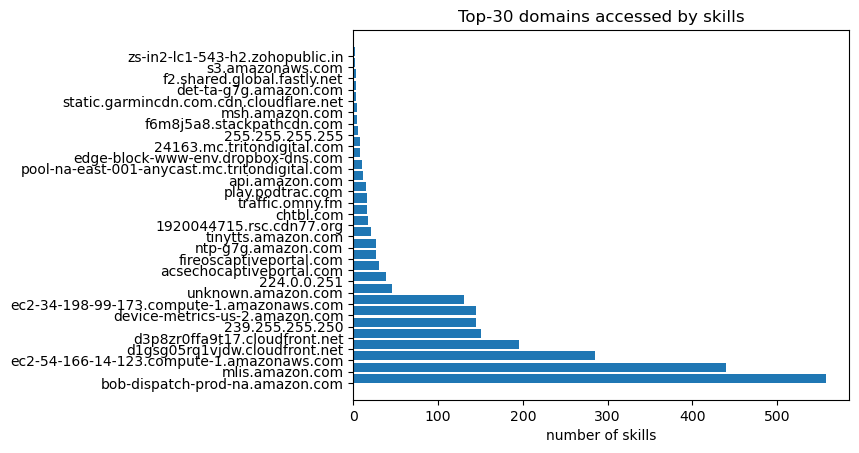

In [44]:
#labels = [fqdn for fqdn, skills_nums in fqdn_skill_num_sorted.items()]
#nums = [skills_nums for fqdn, skills_nums in fqdn_skill_num_sorted.items()]


import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
fqdns = [fqdn for fqdn, skills_nums in fqdn_skill_num_sorted.items()][0:30]
y_pos = np.arange(0,30,1)
performance = [skills_nums for fqdn, skills_nums in fqdn_skill_num_sorted.items()][0:30]
#error = np.random.rand(len(fqdns))

ax.barh(y_pos, performance, align='edge')
ax.set_yticks(y_pos)
ax.set_yticklabels(fqdns)
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('number of skills')
ax.set_title('Top-30 domains accessed by skills')

plt.show()


In [65]:
fqdn_skill

{'52.119.198.106': {'B071J1VW29'},
 '52.94.240.157': {'B0747GRGWH'},
 'scloudfront.net': {'B06ZZF8FRH', 'B072ML3N6K', 'B07FDNYMB6'},
 'ec2-44-198-224-47.compute-1.amazonaws.com': {'B018WUNBE6',
  'B01F9KW5G2',
  'B01LWR1HF9',
  'B01LWX3TFV',
  'B01MRM361G',
  'B01MZFIEL6',
  'B01N1ZVI7M',
  'B01N6BBDLI',
  'B01N6NDMHX',
  'B07122VQJJ',
  'B071672K2R',
  'B073NQDXJ1',
  'B074CNX3G8',
  'B079BYLF7H',
  'B07B6FLP91',
  'B07BY6RRFK',
  'B07CQCPXJ4',
  'B07DT7F925',
  'B07J3CSRJV',
  'B07JVHKVJ2',
  'B07K8LHWRD',
  'B07NW8GZPV',
  'B07QYF6NGN',
  'B07VNTVM3X',
  'B0865C3XG8',
  'B087CQCFSM',
  'B089NC25Z8',
  'B089Y3NJ49',
  'B08F2R7P2H',
  'B08K882PZB'},
 '52.119.196.28': {'B01MS65H9N'},
 '205.251.243.55': {'B01H9HYB74', 'B01L2VVWYI'},
 '52.94.243.11': {'B0193ZD0EU',
  'B01C9JQFFI',
  'B01DJOK2DI',
  'B01EZA6O8W',
  'B01GQSHD18',
  'B01GY2FTIK',
  'B01IMNBJ0Q',
  'B01J0DFHBE',
  'B01JXP09PI',
  'B01LZSIYV5',
  'B01M13Z35T',
  'B01M32CNSL',
  'B01MT3WAUS',
  'B01N36UKXS',
  'B06W2M1SVN',
  